# Object Detection (Images/Videos) with DINOv3

This notebook demonstrates using DINOv3 for object detection using a frozen DINOv3 Backbone and 
a lightweight DETR style decoder trained on COCO dataset (as mentioned in DINOv3 paper). We will use 
the pre-trained weights provided by the authors.

Given:
- RGB video frame(s)

We will extract bounding boxes with their scores and labels from each frame.

- **Setup:**
    - Make a virtual environment (using conda or venv)
    - Install torch, torchvision compatible with your system
    - Install other required dependencies to run this notebook
        - lovely-tensors
        - mediapy
        - tqdm
        - opencv-python
    - Clone the DINOv3 github repo on your local machine
    - Download the weights (you need to sign an agreement)
    - Move the downloaded weights to the `weights` folder inside the dinov3 repo
    - Run the below script (adjust the file location changes)

In [4]:
import datetime
import functools
import io
import logging
import math
import os
from pathlib import Path
import tarfile
import time
import urllib

import lovely_tensors
import matplotlib.pyplot as plt
import mediapy as mp
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as TVT
import torchvision.transforms.functional as TVTF
from torch import Tensor, nn
from tqdm import tqdm

DISPLAY_HEIGHT = 200
lovely_tensors.monkey_patch()
torch.set_grad_enabled(False)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"
# Set the environment variable
os.environ["DINOV3_LOCATION"] = "/data/hardik/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

# set cuda to gpu 1
torch.cuda.set_device(6)

DINOv3 location set to /data/hardik/dinov3


In [5]:
import torchvision

def make_transform(resize_size: int = 224):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

In [26]:
# here we load the DINOv3 model based object detector. We need to specify two file locations: backbone weights & decoder weights(adaptor head)
detector = torch.hub.load(DINOV3_LOCATION, 'dinov3_vit7b16_de', source="local", 
    weights='/data/hardik/dinov3/weights/dinov3_vit7b16_coco_detr_head-b0235ff7.pth', 
    backbone_weights='/data/hardik/dinov3/weights/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth'
    )

2025-09-02 16:25:25,075 - INFO - using base=100 for rope new
2025-09-02 16:25:25,079 - INFO - using min_period=None for rope new
2025-09-02 16:25:25,079 - INFO - using max_period=None for rope new
2025-09-02 16:25:25,079 - INFO - using normalize_coords=separate for rope new
2025-09-02 16:25:25,079 - INFO - using shift_coords=None for rope new
2025-09-02 16:25:25,080 - INFO - using rescale_coords=2 for rope new
2025-09-02 16:25:25,080 - INFO - using jitter_coords=None for rope new
2025-09-02 16:25:25,080 - INFO - using dtype=fp32 for rope new
2025-09-02 16:25:25,103 - INFO - using swiglu64 layer as FFN
0.1%

Downloading: "file:///data/hardik/dinov3/weights/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth" to /home/hardik/.cache/torch/hub/checkpoints/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth


100.0%
2025-09-02 16:28:27,619 - INFO - Wrapping with 3 x 3 windows
5.6%

Downloading: "file:///data/hardik/dinov3/weights/dinov3_vit7b16_coco_detr_head-b0235ff7.pth" to /home/hardik/.cache/torch/hub/checkpoints/dinov3_vit7b16_coco_detr_head-b0235ff7.pth


100.0%


In [27]:
detector.to("cuda")
detector.eval()

DetectorWithProcessor(
  (detector): PlainDETRReParam(
    (transformer): TransformerReParam(
      (decoder): GlobalDecoder(
        (layers): ModuleList(
          (0-5): 6 x GlobalDecoderLayer(
            (cross_attn): GlobalCrossAttention(
              (cpb_mlp1): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=8, bias=False)
              )
              (cpb_mlp2): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=8, bias=False)
              )
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
    

In [28]:
# To load video frames from local repo
def load_video_frames_from_local_dir(video_path: str) -> list[Image.Image]:
    frames = []
    for frame_path in sorted(Path(video_path).glob("*.png")):
        image = Image.open(frame_path).convert("RGB")
        frames.append(image)
    return frames

video_path = "/data/hardik/dinov3/samples/kitti_samples"
frames = load_video_frames_from_local_dir(video_path)
num_frames = len(frames)
print(f"Number of frames: {num_frames}")

original_width, original_height = frames[0].size
print(f"Original size: width={original_width}, height={original_height}")

Number of frames: 118
Original size: width=1242, height=375


In [29]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps


def get_local_img(filepath):
    image = Image.open(filepath).convert("RGB")
    # if needed, crop the black part from the image frame in both dimension. Width - 314 pixels on left and right , Height - 100 pixels from top and bottom
    image = image.crop((314, 100, image.width - 314, image.height - 100))
    return image

class ResizeToMultiple(nn.Module):
    def __init__(self, short_side: int, multiple: int):
        super().__init__()
        self.short_side = short_side
        self.multiple = multiple

    def _round_up(self, side: float) -> int:
        return math.ceil(side / self.multiple) * self.multiple

    def forward(self, img):
        old_width, old_height = TVTF.get_image_size(img)
        if old_width > old_height:
            new_height = self._round_up(self.short_side)
            new_width = self._round_up(old_width * new_height / old_height)
        else:
            new_width = self._round_up(self.short_side)
            new_height = self._round_up(old_height * new_width / old_width)
        return TVTF.resize(img, [new_height, new_width], interpolation=TVT.InterpolationMode.BICUBIC)



def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])



In [30]:
SHORT_SIDE = min(original_height, original_width)
patch_size = 16

transform = TVT.Compose(
    [
        ResizeToMultiple(short_side=SHORT_SIDE, multiple=patch_size),
        TVT.ToTensor(),
        TVT.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Let's try to do a forward pass on first frame


In [31]:
img  = frames[0]
with torch.inference_mode():
    batch_img = transform(img)[None].to('cuda')
    pred_vit7b = detector(batch_img)  # raw predictions  

# Let's look at the model's predictions
pred_vit7b[0].keys()

/data/hardik/anaconda/envs/dinov3/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


dict_keys(['scores', 'labels', 'boxes'])

In [34]:
# Visualize the object detectors on the image:
def plot_results(pil_img, det):
    '''
    Visualize the object detection results on the image.
    det:
        {'scores': tensor[1500] 5.9Kb x∈[0.004, 0.935] μ=0.011 σ=0.053 cuda:0,
        'labels': tensor[1500] i64 12Kb x∈[1, 90] μ=55.273 σ=24.257 cuda:0,
        'boxes': tensor[1500, 4] n=6000 (23Kb) x∈[0., 896.000] μ=380.023 σ=328.002 cuda:0}] 
    '''
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for score, label, box in zip(det['scores'], det['labels'], det['boxes']):
        if score.item() > 0.5:  # threshold
            x0, y0, x1, y1 = box.cpu().numpy()
            ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='red', linewidth=2))
            ax.text(x0, y0, f'{label.item()}: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

In [47]:
# COCO class names (1-indexed, 0 is background or unused)
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

def plot_results(pil_img, det):
    '''
    Visualize the object detection results on the image.
    det:
        {'scores': tensor[1500], 'labels': tensor[1500], 'boxes': tensor[1500, 4]}
    '''
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for score, label, box in zip(det['scores'], det['labels'], det['boxes']):
        if score.item() > 0.75:  # threshold
            x0, y0, x1, y1 = box.cpu().numpy()
            class_idx = int(label.item())
            class_name = COCO_CLASSES[class_idx] if 0 <= class_idx < len(COCO_CLASSES) else str(class_idx)
            ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='red', linewidth=2))
            ax.text(x0, y0, f'{class_name}: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

## Here we plot the detections on first frame

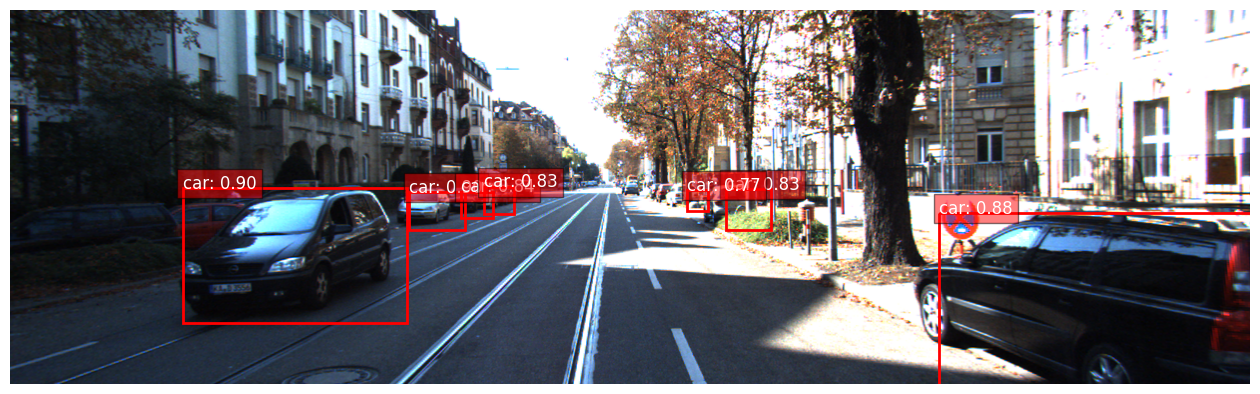

In [48]:
plot_results(img, pred_vit7b[0])

In [37]:
# Object Detection on the Video. We do it batchwise 
BATCH_SIZE = 16
processed_frames = []
for i in tqdm(range(0, num_frames, BATCH_SIZE),desc="Processing frames"):
    batch_frames = frames[i:i + BATCH_SIZE]
    # Process the batch of frames
    batch_inputs = [transform(frame) for frame in batch_frames]
    batch_inputs = torch.stack(batch_inputs).to('cuda')
    with torch.inference_mode():
        outputs = detector(batch_inputs)
    # Process the outputs
    processed_frames.extend(outputs)


Processing frames: 100%|██████████| 8/8 [01:32<00:00, 11.60s/it]


In [49]:
import cv2
import mediapy as mp

# function to plot detection on video frames
def video_with_detections(frames, detections, threshold=0.5):
    # draw bbox on the frames and store them for visualization
    frames_with_detections = []
    for i, (frame, detection) in enumerate(zip(frames, detections)):
        bboxes, scores, labels = detection['boxes'], detection['scores'], detection['labels']
        # Draw the bounding boxes on the original frame
        curr_frame = frame.copy()
        curr_frame = np.array(curr_frame)
        for (bbox, score, label) in zip(bboxes, scores, labels):
            if score.item()> threshold:
                x1, y1, x2, y2 = bbox.cpu().numpy().astype(int)
                class_idx = int(label.item())
                class_name = COCO_CLASSES[class_idx] if 0 <= class_idx < len(COCO_CLASSES) else str(class_idx)
                cv2.rectangle(curr_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(curr_frame, f"{class_name}: {score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        frames_with_detections.append(curr_frame.astype(np.uint8))

    
    return frames_with_detections

## Finally, let's visualize model's perfomance on our video. 

In [52]:
os.makedirs('../output', exist_ok=True)
frames_with_detections = video_with_detections(frames, processed_frames, threshold=0.5)
output_dir = '../output'
mp.set_show_save_dir(output_dir)
mp.show_video(frames_with_detections, 
                    height=DISPLAY_HEIGHT,
                    fps=2,
                    title="Video with Object Detections",)
    